In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
processed_dataset  = "processed_data"

# Neural networks micro framework

In [4]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

In [5]:
def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[1] / 2.), k - int(W.shape[2] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[2] / 2.) ,G.shape[2] - int(W.shape[2] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[1] / 2.), G.shape[1] - int(W.shape[1] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

In [6]:
def relu(x,w = 1.,b = 0.):
    return jnp.maximum(0,x * w + b)

def sigmoid(x,w = 1.,b = 0.):
    return (jnp.tanh(x * w + b) + 1.)/2.

def tanh(x,w=1.,b=0.):
    return jnp.tanh(x * w + b)

In [7]:
def linear(layer,W,b):
    return W @ layer + b

def add(layer,b):
    return layer + b

# Loading npy(s)

In [36]:
import os
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []


for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(voxelization)
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
10 su 101
20 su 101
30 su 101
40 su 101
50 su 101
60 su 101
70 su 101
80 su 101
90 su 101
100 su 101


In [37]:
shapes      = np.array([ np.array(a.shape) for a in voxelizations ])
magic_shape = shapes.max(axis = 0)
magic_shape

array([74, 66, 81])

## Conversione dei dati caricati in formato array

In [53]:
voxelizations       = [ jnp.array(o) for o in voxelizations      ]
voxelization_specs  = [ jnp.array(o) for o in voxelization_specs ]
centers_of_mass     = [ jnp.array(o) for o in centers_of_mass    ]
finger_prints       = [ jnp.array(o) for o in finger_prints      ]

# Center of mass gaussianization

In [54]:
def center_of_mass_gaussianization(
        com,                      # centro di massa
        voxelization_orig_shape , # dimensione della voxelizzazione prima di essere paddata
        voxelization_specs      , # specifiche geometriche della voxelizzazioen (xmin,xmax,ymin,ymax,zmin,zmax)
        sigma = 5.                # deviazione standard della gaussiana
):
    # ritorna una voxelgrid in cui il centro di massa é rappresentato attraverso una gaussiana 
    # di varianza sigma_sq
    
    grid = np.zeros((voxelization_orig_shape[0],
                     voxelization_orig_shape[1],
                     voxelization_orig_shape[2]))
    
    x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs

    X   = jnp.linspace(x_min,x_max, voxelization_orig_shape[0])
    Y   = jnp.linspace(y_min,y_max, voxelization_orig_shape[1])
    Z   = jnp.linspace(z_min,z_max, voxelization_orig_shape[2])
    
    # faccio il meshgrid dei linspace
    XYZ = jnp.meshgrid(X,Y,Z, indexing = 'ij')

    
    grid =  jax.vmap(
                        lambda x,y,z: 
                            jnp.exp( - (
                                        (x - com[0])**2 +      
                                        (y - com[1])**2 + 
                                        (z - com[2])**2
                                       ) / (sigma**2)           # divido per la varianza
                                   )
                    )(XYZ[0],
                      XYZ[1],
                      XYZ[2])


    grid = np.array(grid)
    return grid
    

In [55]:
voxelization_specs[0]

DeviceArray([-1.307, 26.864, -9.073, 20.774, 13.342, 41.422], dtype=float32)

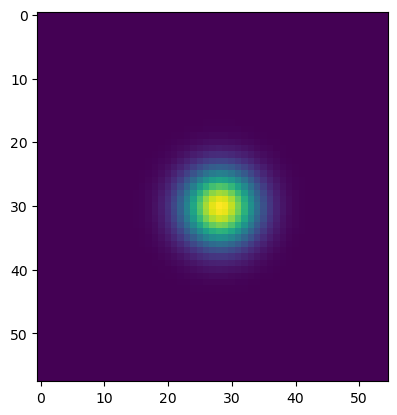

In [56]:
com_g = center_of_mass_gaussianization(
    centers_of_mass[0],
    voxelizations[0].shape,
    voxelization_specs[0],
    3.
)
plt.imshow(com_g.mean(axis = 0))

# Padding

In [57]:
def padding(array, requested_shape):
    xx = requested_shape[0]
    yy = requested_shape[1]
    zz = requested_shape[2]
    
    sa = array.shape[0]
    sb = array.shape[1]
    sc = array.shape[2] 
    
    a = (xx - sa) // 2
    aa = xx - a - sa
    b = (yy - sb) // 2
    bb = yy - b - sb
    c = (zz - sc) // 2
    cc = zz - c - sc
    
    return jnp.pad(array, pad_width=((a, aa), (b, bb), (c,cc)), mode='constant')

In [77]:
def extract_batch(magic_shape     ,   # magic shape
                  voxel_list      ,   # lista delle voxelizzazioni 
                  voxel_spec_list ,   # lista delle specifiche delle voxelizzazioni
                  com_list        ,   # lista dei centri di massa
                  sigma           ,   # sigma 
                  idx_list):          # lista degli indici da prendere
    return (
            jnp.array([                                       # padding delle voxelizzazioni
                    padding(
                        voxel_list[idx] , 
                        magic_shape
                    )
                for idx in idx_list
            ]),
            jnp.array([
                    padding(
                        center_of_mass_gaussianization(
                            com_list[idx],
                            voxel_list[idx].shape,
                            voxel_spec_list[idx],
                            sigma
                        ),
                        magic_shape
                    )
                for idx in idx_list
            ])
    )

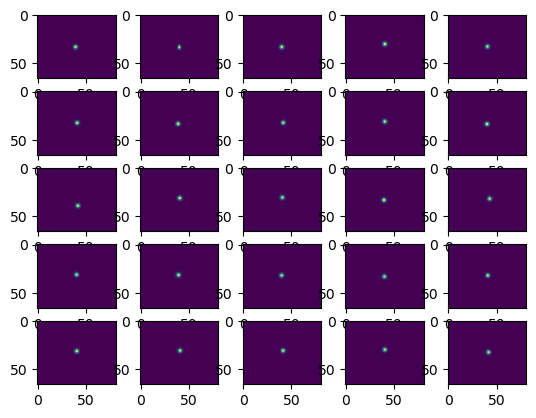

In [78]:
n = 5
vox,com = extract_batch(
    magic_shape,
    voxelizations,
    voxelization_specs,
    centers_of_mass,
    sigma = 1.0,
    idx_list = np.random.choice(len(voxelizations), size = (n**2))
)

axs = plt.figure().subplots(n,n).flatten()
for i,a in enumerate(axs):
    a.imshow(com[i].mean(axis = 0))
    

# Network

###  Rete

In [79]:
def logistic_model(kernels_tensor_flux, 
                   biases_tensor_flux,                   
                   grid):
        
    x            = conv3D(grid, 
                          kernels_tensor_flux[0])
    x            = relu(x ,
                        b = biases_tensor_flux[0])
    
    for W,b in zip(kernels_tensor_flux[1:][:-1], biases_tensor_flux[1:][:-1]):
        x        = conv3D(x,  W)
        x        = relu(x,b = b)
    
    x            = conv3D(x, kernels_tensor_flux[-1])
    x            =    add(x, biases_tensor_flux[-1] )
    
    return x
    

def generate_params_big_model( flux_topology ):
    
    kernels_tensor_flux = []
    biases_tensor_flux  = []
    
    for k in flux_topology:
        kernels_tensor_flux.append( 
            jnp.array(
                np.random.normal(
                    size = (k,k,k)
                ) 
                * 
                np.sqrt(
                    2./ (k * k * k)
                )
            ) 
        )
        biases_tensor_flux.append(0.)

    
    return kernels_tensor_flux, biases_tensor_flux

### Loss function

In [80]:
def loss(    
       kernels_tensor_flux, 
       biases_tensor_flux,
       grid,
       A):
    
    A_hat = logistic_model(
                   kernels_tensor_flux, 
                   biases_tensor_flux,
                   grid)
    
    
    return ((A - A_hat)**2).mean()


loss = jax.jit(loss)
grad = jax.grad(loss,argnums = (0,1))
grad = jax.jit(grad)

In [81]:
def batch_loss(    
                   kernels_tensor_flux, 
                   biases_tensor_flux,
    
                   grids,
                   As):
    
    
        return jax.vmap(
          lambda 
              grid, A:
              (
                  (
                    logistic_model( 
                                    kernels_tensor_flux, 
                                    biases_tensor_flux,
                                    grid
                                   ) 
                     - A)**2 * (A > 0.0)
                   ).mean() / (A > 0.0).mean()
              )(
                  grids,
                  As
              ).mean()
    
batch_loss = jax.jit(batch_loss)
batch_grad = jax.grad(batch_loss,argnums = (0,1))
batch_grad = jax.jit(batch_grad)

# Training

## Random generated parameters

In [82]:
np.random.seed(123)
ktf, btf = generate_params_big_model( [5 for k in range(12)])

## Training Loop

$(1 - T)^E\sigma_0 = \sigma_F$ <br>
$log\left( (1 - T)^E\sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$log\left( (1 - T)^E \right) + log\left( \sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$E log\left( (1 - T) \right) + log\left( \sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$log\left( (1 - T) \right)  = \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right)$ <br>
$\left( (1 - T) \right)  =  exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$<br>
$ -T  =  - 1 + exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$ <br>
$ T  =  1 - exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$ 
<br>

0.004594582648473011
0
	0.07321
	0.07180
	0.07019


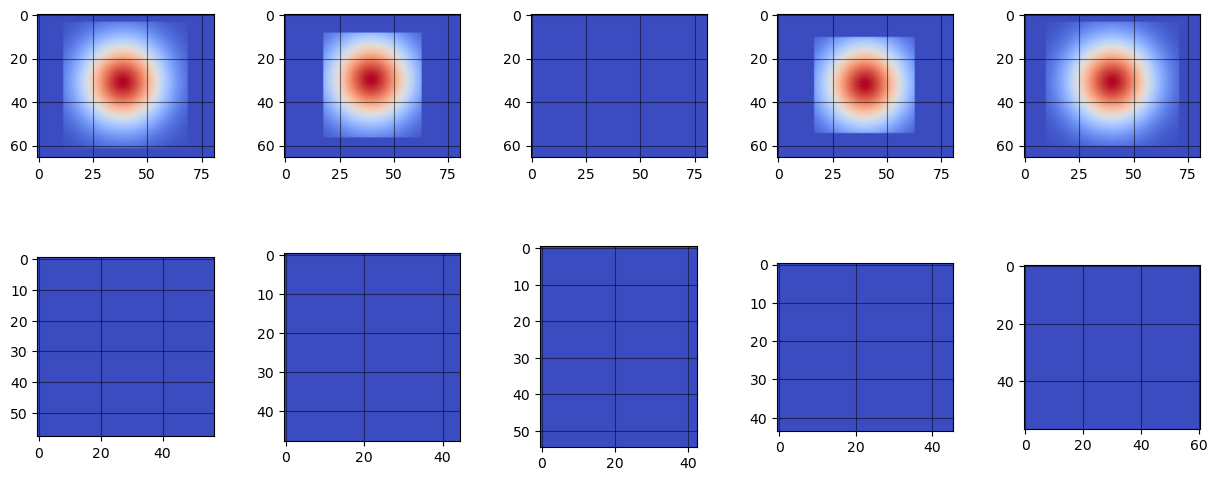

0.071733445
1
	0.06214
	0.05418
	0.04960


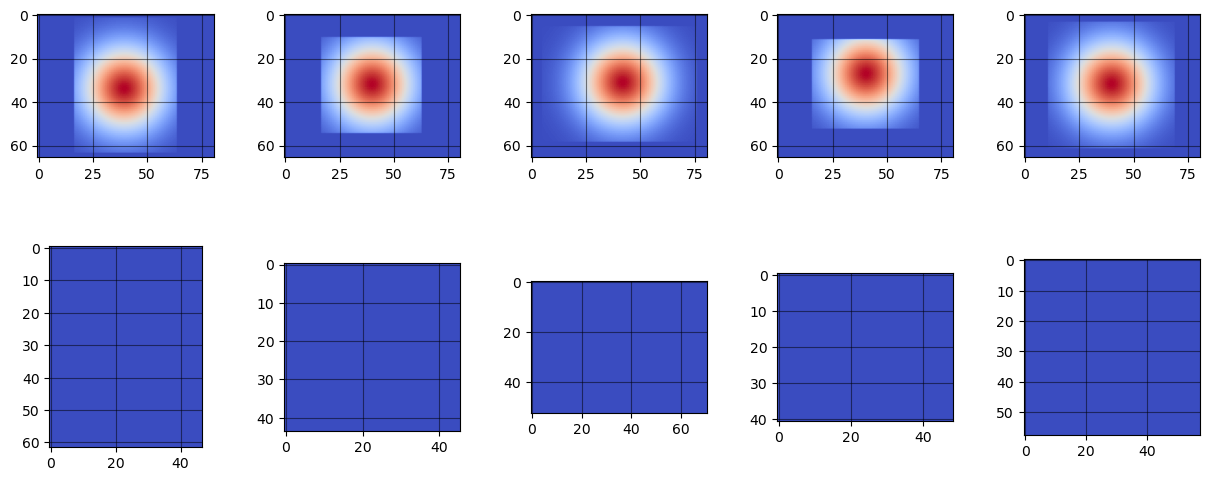

0.055307638
2
	0.04686


In [ ]:
np.random.seed(123)
errors = []
losses = []

sigma_0 = sigma  = 10.
sigma_F = 1.0
epochs = 500

T      = 1 - np.exp( (1./epochs) * ( np.log(sigma_F) - np.log(sigma_0) )  )
print(T)
for e in range(epochs):
    sigma =  (1 - T) * sigma
    
    print(e)
    batches_n  = 3
    
    indici     = np.random.choice(len(voxelizations),
                                  len(voxelizations),
                                  False)
    batches    = np.array_split( indici , batches_n)
    
    
    for batch in batches:
        vox,com = extract_batch(
            magic_shape,
            voxelizations,
            voxelization_specs,
            centers_of_mass,
            sigma = sigma,
            idx_list = batch
        )
            
        g      = batch_grad(    ktf,
                                btf,
                                vox,
                                com)
        lr  = 1e-1
        
        ktf = [ k - lr * gr for k,gr in zip(ktf, g[0])]
        btf = [ b - lr * gr for b,gr in zip(btf, g[1])]
        
        curr_loss = batch_loss( ktf,
                                btf,
                                vox,
                                com)
        
        errors.append(curr_loss)
        losses.append(np.mean(errors[-batches_n:]))
        print("\t%.5f" % curr_loss)
        
    #########################################################################################
    
    fetta = 15
    axs = plt.figure(figsize=(15,6)).subplots(2,5)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.4) 

    
    samples = np.random.choice(len(voxelizations), size = 5)
    
    _,com   = extract_batch(
            magic_shape,
            voxelizations,
            voxelization_specs,
            centers_of_mass,
            sigma = sigma,
            idx_list =  samples
        )
    
    for img,sample in enumerate(samples):
        axs[0,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')
        axs[1,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')


        axs[0,img].imshow( com[img][fetta,:,:] , cmap = 'coolwarm')
        
        axs[1,img].imshow( logistic_model(
                                  ktf, 
                                  btf,
                                  voxelizations[sample]
                                )[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
    
    plt.show()
    
    
    
    print(losses[-1])
    
    
plt.figure()
plt.plot(losses)

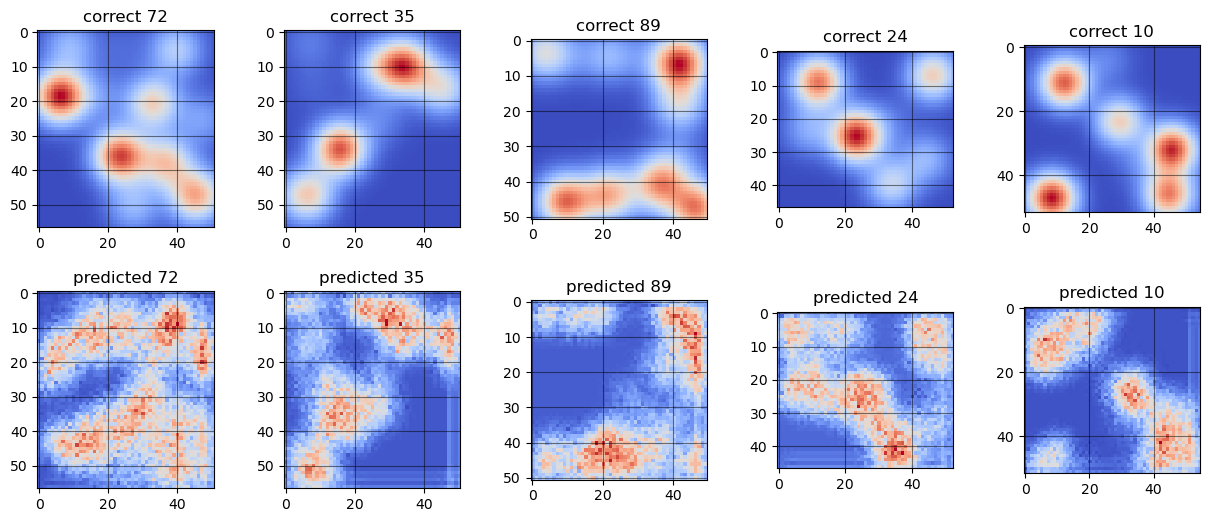

In [29]:
axs = plt.figure(figsize=(15,6)).subplots(2,5)
plt.subplots_adjust(hspace = 0.3, wspace = 0.4) 

#np.random.seed(789)

for img in range(5):

    sample = np.random.choice(len(ligand_test))
    
    axs[0,img].set_title("correct %d" % sample)
    axs[0,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')
    
    axs[1,img].set_title("predicted %d" % sample)    
    axs[1,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')

    axs[0,img].imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'coolwarm')
    axs[1,img].imshow( logistic_model(
                              ktf, btf, wo, bo,
                              atomcoord_vox_test[sample],
                              ligand_test[sample], 
                              1.0)[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
    
    
plt.show()

## Save Big Model

In [30]:
import os

big_models_folders = "big_models"
N_models = len(next(os.walk(big_models_folders))[1])
new_folder_id = N_models


# creo la cartella
path_curr_model = big_models_folders + "/" + str(new_folder_id)
path_curr_model_ktf = "%s/ktf" % (path_curr_model)
path_curr_model_btf = "%s/btf" % (path_curr_model)
path_curr_model_wo  = "%s/wo"  % (path_curr_model)
path_curr_model_bo  = "%s/bo"  % (path_curr_model)

os.mkdir(path_curr_model)
os.mkdir(path_curr_model_ktf)
os.mkdir(path_curr_model_btf)
os.mkdir(path_curr_model_wo)
os.mkdir(path_curr_model_bo)


# Salvo i kernel
for i,k in enumerate(ktf):
    np.save(path_curr_model_ktf + ("/kernel_%d" % i) , np.array(k))

# Salvo i bias convolutivi
for i,b in enumerate(btf):
    np.save(path_curr_model_btf + ("/bias_%d" % i) , b)
    
# Salvo i weights dell'oracolo
for i,w in enumerate(wo):
    np.save(path_curr_model_wo + ("/weight_oracle_%d" % i) , w)

# Salvo i bias dell'oracolo
for i,b in enumerate(bo):
    np.save(path_curr_model_bo + ("/bias_oracle_%d" % i) , b)    


## salvo file con alcune informazioni
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

# convert datetime obj to string
str_current_datetime = str(current_datetime)
# 
## create a file object along with extension
file_name = str_current_datetime+".log"
file = open(path_curr_model + "/" + file_name, 'w')
file.write(str_current_datetime + "\n")
file.write("TEST LOSS = %.10f\n" % batch_loss(  ktf, btf, wo, bo,
                                   extract_batch(magic_shape,atomcoord_vox_train,np.arange(len(ligand_test))),
                                   ligand_test,
                                   1.0,
                                   extract_batch(magic_shape,anchorpts_vox_train,np.arange(len(ligand_test)))))
file.close()


# salvo una copia dell autoencoder ligandi...

path_curr_model_encoder = "%s/ligand_encoder" % (path_curr_model)
path_curr_model_decoder = "%s/ligand_decoder" % (path_curr_model)

os.mkdir(path_curr_model_encoder)
os.mkdir(path_curr_model_decoder)

# Salvo l'encoder
for i,e in enumerate(params_E):
    np.save(path_curr_model_encoder + ("/encoder_param_%d" % i) , np.array(e))

# Salvo il decoder
for i,d in enumerate(params_D):
    np.save(path_curr_model_decoder + ("/decoder_param_%d" % i) , np.array(d))

# Test

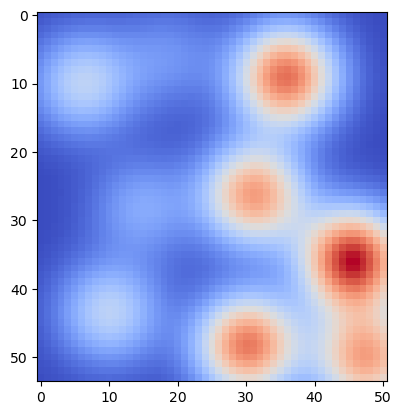

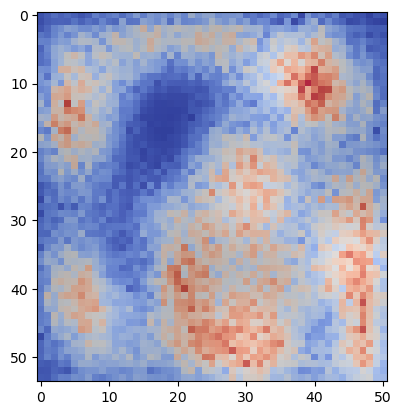

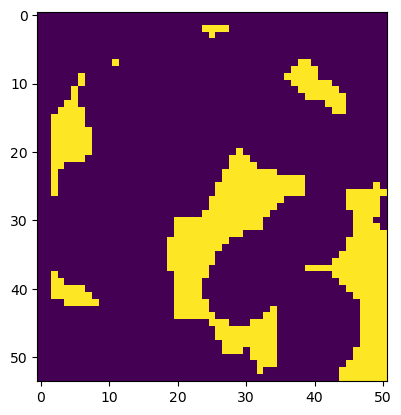

In [31]:
fetta = 20
sample = 1
plt.imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'coolwarm')
plt.figure()
plt.imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'gray')
plt.imshow(logistic_model(
                          ktf, btf, wo, bo,
                          atomcoord_vox_test[sample],
                          ligand_test[sample], 
                          1.0)[fetta,:,:] , alpha = 0.8, cmap = 'coolwarm' )
plt.figure()
plt.imshow( atomcoord_vox_test[sample][fetta,:,:])
plt.show()

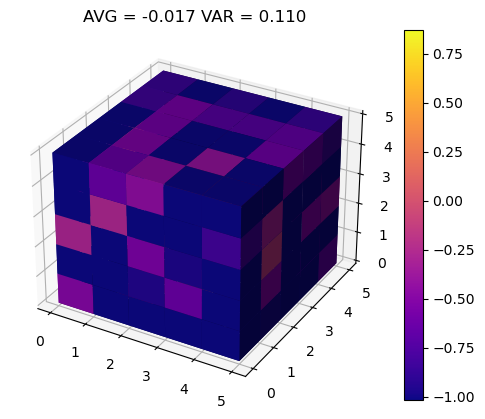

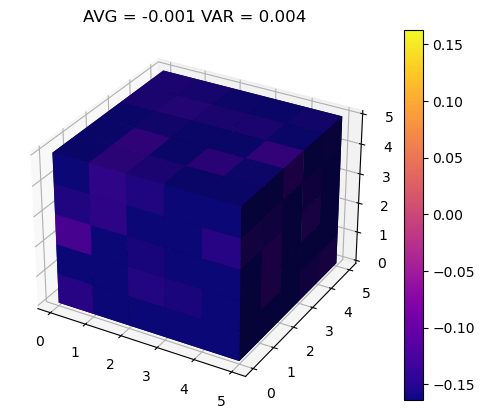

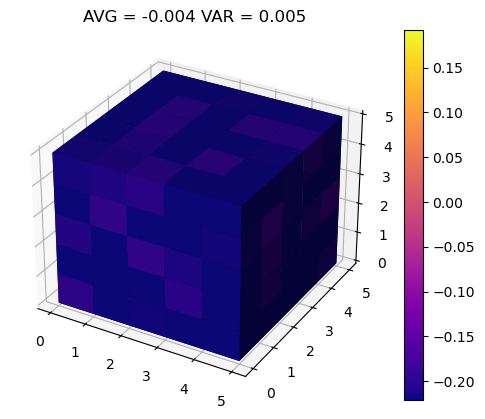

In [32]:
from matplotlib import colors,cm
for s in [10,20,30]:
    fig    = plt.figure()
    ax     = fig.add_subplot(projection = '3d')
    img    = chemical_contribution(wo,bo,ligand_train[s])
    ax.set_title("AVG = %.3f VAR = %.3f" % (img.mean(),img.var()))
    colori = plt.cm.plasma(img)
    v      = ax.voxels( img, facecolors = colori, alpha = 1. )

    norm = colors.Normalize(vmin=img.min(), vmax=img.max())
    m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    plt.show()


In [82]:
sample = 17
V_A_hat = np.array  (
                    logistic_model
                                 (
                                      ktf, btf, wo, bo,
                                      atomcoord_vox_train[sample],
                                      ligand_train[sample], 
                                      1.0
                                 )
                    )
V_A     = np.array(anchorpts_vox_test[sample])
V_X     = np.array(atomcoord_vox_test[sample])

(array([44926., 29631., 19154., 17809., 18000., 16206., 16518., 17165.,
        15483.,   784.]),
 array([-0.03026948,  0.03291195,  0.09609338,  0.1592748 ,  0.22245623,
         0.28563765,  0.34881908,  0.4120005 ,  0.47518194,  0.5383634 ,
         0.6015448 ], dtype=float32),
 <BarContainer object of 10 artists>)

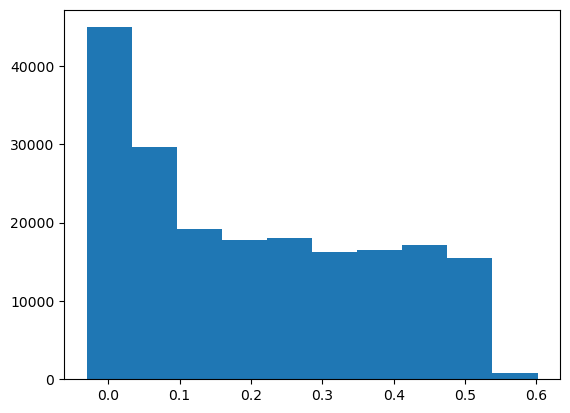

In [83]:
plt.hist( V_A_hat.flatten() )

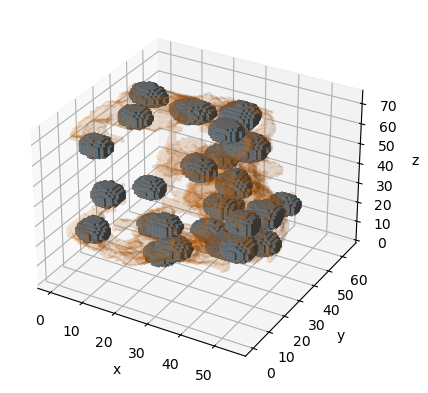

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(V_A > 0.7, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

ax = make_ax(True)
ax.voxels(V_A_hat > (0.8 * (V_A_hat.max() - V_A_hat.min()) + V_A_hat.min()), edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

In [ ]:
V_A_hat.shape

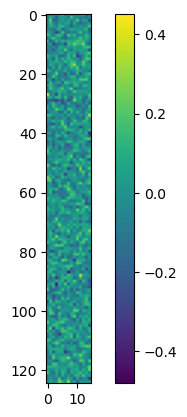

In [64]:
plt.imshow(W_6)
plt.colorbar()

In [127]:
b_f_4

DeviceArray(0.03047841, dtype=float32, weak_type=True)

$f({\bf x} + H_f^{-1} \nabla f({\bf x}) ) \approx f({\bf x}) + \nabla f({\bf x})^T H_f^{-1} \nabla f({\bf x})  + \nabla f({\bf x})^T H_f^{-1}  H_f({\bf x}) H_f^{-1} \nabla f({\bf x}) $

In [57]:
v = np.arange(5)**2
v[[0,2,3]]

array([0, 4, 9])